The code here is heavily based on the code from this fastai binary segmentation tutorial: https://walkwithfastai.com/Binary_Segmentation (walkwithfastai is a fastai tutorial website by Zach Mueller), as well as this google colab notebook (https://colab.research.google.com/github/walkwithfastai/walkwithfastai.github.io/blob/master/nbs/course2020/vision/07_Binary_Segmentation.ipynb) that is from the tutorial webpage listed above.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/CS\ 269\ Final\ Project

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1D7-XvnrgJ1RYOpB4A4_0Sq_4Nc3FHbQh/CS 269 Final Project


In [2]:
!pip install fastai wwf -q --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.8 MB/s eta 0:00:00


In [3]:
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai` : 2.7.15 
* `fastcore` : 1.5.46 
* `wwf` : 0.0.16 
---

In [4]:
from fastai.vision.all import *

In [5]:
%cd /content/
os.makedirs("post_burned_tiles_dataset", exist_ok=True)

/content


In [6]:
%cd /content/drive/MyDrive/CS\ 269\ Final\ Project

/content/drive/.shortcut-targets-by-id/1D7-XvnrgJ1RYOpB4A4_0Sq_4Nc3FHbQh/CS 269 Final Project


# Imports

In [10]:
import pandas as pd
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from torch import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pickle
from torch import optim

In [11]:
import pandas as pd
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from torch import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pickle
from torch import optim
import sys
sys.path.insert(1, '/content/drive/.shortcut-targets-by-id/1D7-XvnrgJ1RYOpB4A4_0Sq_4Nc3FHbQh/CS 269 Final Project/burned-area-baseline')

from neural_net import dataset

# Download dataset + Preprocessing



In [11]:
main_folder = 'Satellite_burned_area_dataset'
satellite_data = pd.read_csv("satellite_data.csv")
# folder_list = satellite_data["folder"] # To use this, move everything from the dataset_unused folder back into the main_folder
folder_list = ['EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector', 'EMSR207_02LOUSA_02GRADING_MAP_v2_vector', 'EMSR207_03PAMPILHOSADASERRA_02GRADING_MAP_v2_vector', 'EMSR207_04AVELAR_02GRADING_MAP_v2_vector', 'EMSR207_05PEDROGAOGRANDE_02GRADING_MAP_v2_vector', 'EMSR207_06MADEIRA_02GRADING_MAP_v2_vector', 'EMSR207_07ALVAIAZERE_02GRADING_MAP_v2_vector', 'EMSR207_08CERNACHEDOBONJARDIM_02GRADING_MAP_v2_vector', 'EMSR207_10ORVALHO_02GRADING_MAP_v2_vector', 'EMSR209_01MOGUER_02GRADING_MAP_v2_vector', 'EMSR209_02MAZAGON_02GRADING_MAP_v2_vector', 'EMSR209_03LOSCABEZUDOS_02GRADING_MAP_v1_vector', 'EMSR209_04CHOZASDELAPOLEOSA_02GRADING_MAP_v1_vector', 'EMSR209_05MAZAGONDETAIL01_02GRADING_MAP_v1_vector', 'EMSR210_04TRASLASIERRA_02GRADING_MAP_v2_vector', 'EMSR210_05ELCAMPILLOOVERVIEW_02GRADING_MAP_v1_vector', 'EMSR211_01SONEJAWEST_02GRADING_MAP_v1_vector', 'EMSR211_02SONEJA_02GRADING_MAP_v1_vector', 'EMSR213_01VESUVIO_02GRADING_MAP_v2_vector', 'EMSR213_03FRANCOFONTE_02GRADING_MAP_v1_vector', 'EMSR213_04AVOLA_02GRADING_MAP_v1_vector', 'EMSR213_06MONREALE_02GRADING_MAP_v2_vector', 'EMSR213_07SANVITOLOCAPO_02GRADING_MAP_v2_vector', 'EMSR213_08BLUFI_02GRADING_MAP_v2_vector', 'EMSR213_09MISTRETTA_02GRADING_MAP_v2_vector', 'EMSR213_10MESSINA_02GRADING_MAP_v1_vector', 'EMSR213_11NASO_02GRADING_MAP_v1_vector', 'EMSR213_12ETNANORD_02GRADING_MAP_v1_vector', 'EMSR214_01OLMETA_02GRADING_MAP_v2_vector', 'EMSR214_02LABASTIDONNE_02GRADING_MAP_v1_vector', 'EMSR214_04MARSEILLE_02GRADING_MAP_v1_vector', 'EMSR214_05LELAVANDOU_02GRADING_MAP_v1_vector', 'EMSR214_06COGOLIN_02GRADING_MAP_v2_vector', 'EMSR216_01LOSCOLLADOS_02GRADING_MAP_v1_vector', 'EMSR216_02TORREPEDRO_02GRADING_MAP_v1_vector', 'EMSR216_04RALA_02GRADING_MAP_v1_vector', 'EMSR216_05ELCALAR_02GRADING_MAP_v2_vector', 'EMSR217_01DUKAT_02GRADING_MAP_v2_vector', 'EMSR217_02VRANISHT_02GRADING_MAP_v1_vector', 'EMSR219_01SEGURADELASIERRA_02GRADING_MAP_v1_vector', 'EMSR221_01OGLIASTRO_02GRADING_MAP_v2_vector', 'EMSR226_01DABA_02GRADING_MAP_v1_vector', 'EMSR227_01ENCINEDO_02GRADING_MAP_v2_vector', 'EMSR227_02CORPORALES_02GRADING_MAP_v2_vector', 'EMSR227_03SANTAEULALIADECABRERA_02GRADING_MAP_v2_vector', 'EMSR237_03ELMADRONO_02GRADING_MAP_v1_vector', 'EMSR237_04ELCASTILLODELASGUARDAS_02GRADING_MAP_v1_vector', 'EMSR239_05ALMADENDELAPLATAOVERVIEW_02GRADING_MAP_v1_vector', 'EMSR248_01PINODELORO_02GRADING_MAP_v1_vector', 'EMSR248_04HOYOSDEMIGUELMUNOZ_02GRADING_MAP_v1_vector', 'EMSR250_01MARINHAGRANDE_02GRADING_MAP_v2_vector', 'EMSR250_04CORTES_02GRADING_MAP_v2_vector', 'EMSR252_02HAUTECORSEDETAIL_02GRADING_MAP_v1_vector', 'EMSR254_01PORTELADEAGUIAR_02GRADING_MAP_v2_vector', 'EMSR254_02SILVAN_02GRADING_MAP_v2_vector', 'EMSR254_03PERENADELARIBERA_02GRADING_MAP_v2_vector', 'EMSR281_01KIRTOMY_02GRADING_MAP_v1_vector', 'EMSR290_03MANSBO_02GRADING_MAP_v1_vector', 'EMSR298_02HAMMARSTRAND_02GRADING_MAP_v1_vector', 'EMSR298_05STRANDASMYRVALLEN_02GRADING_MAP_v1_vector', 'EMSR298_06GROTINGEN_02GRADING_MAP_v1_vector', 'EMSR302_01NERVA_02GRADING_MAP_v1_vector', 'EMSR302_07ELPERALEJO_02GRADING_MAP_v1_vector', 'EMSR365_AOI01_GRA_PRODUCT_r1_RTP01_v1_vector', 'EMSR368_AOI01_GRA_PRODUCT_r1_RTP01_v3_vector', 'EMSR371_AOI01_GRA_PRODUCT_r1_RTP01_v2_vector', 'EMSR372_AOI04_GRA_PRODUCT_r1_RTP01_v3_vector', 'EMSR373_AOI01_GRA_PRODUCT_r1_RTP01_v2_vector']
# folder_list = ['EMSR237_03ELMADRONO_02GRADING_MAP_v1_vector']

dataset_config = {
        'folder': main_folder,
        'mask_intervals': [(0, 36), (37, 255)],
        'mask_one_hot': False,
        'height': 512,
        'width': 512,
        'product_list': ['sentinel2'],
        'mode': 'post',
        'filter_validity_mask': True,
        'transform': None,
        'process_dict': {
            'sentinel2': [0, 1, 2]
        },
        'activation_date_csv': "satellite_data.csv",
        'mask_filtering': False,
        'only_burnt': True
    }

# import pdb; pdb.set_trace()
ds_temp = dataset.SatelliteDataset(folder_list=folder_list, **dataset_config)
# ds = dataset.SatelliteDataset(folder_list=folder_list, **dataset_config)
# If you run into issues, uncomment the following code for debugging
# If you run out of RAM, remove some folders from the folder here
# I removed some folders: they are now in dataset_unused

# for folder in folder_list:
#     print(f"Trying to load data from folder: {folder}")
#     try:
#         ds_temp = dataset.SatelliteDataset(folder_list=[folder], **dataset_config)  # Create a temporary dataset with just one folder
#         print(f"Successfully loaded data from folder: {folder}")
#     except Exception as e:
#         print(f"Error loading data from folder {folder}: {e}")

Empty folder found Satellite_burned_area_dataset/EMSR211_01SONEJAWEST_02GRADING_MAP_v1_vector for product sentinel2


/content/drive/.shortcut-targets-by-id/1D7-XvnrgJ1RYOpB4A4_0Sq_4Nc3FHbQh/CS 269 Final Project/burned-area-baseline/neural_net/image_processor.py:343: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  result = rescale(img, max(rescale_height, rescale_width), multichannel=True)


Invalid product requested:
root: Satellite_burned_area_dataset
folder: EMSR211_01SONEJAWEST_02GRADING_MAP_v1_vector
product: sentinel2
mode: post
date: 
Invalid product requested:
root: Satellite_burned_area_dataset
folder: EMSR214_02LABASTIDONNE_02GRADING_MAP_v1_vector
product: sentinel2
mode: post
date: 2017-08-18
Invalid product requested:
root: Satellite_burned_area_dataset
folder: EMSR250_04CORTES_02GRADING_MAP_v2_vector
product: sentinel2
mode: post
date: 2017-10-22
Invalid product requested:
root: Satellite_burned_area_dataset
folder: EMSR252_02HAUTECORSEDETAIL_02GRADING_MAP_v1_vector
product: sentinel2
mode: post
date: 2017-10-24
Invalid product requested:
root: Satellite_burned_area_dataset
folder: EMSR254_01PORTELADEAGUIAR_02GRADING_MAP_v2_vector
product: sentinel2
mode: post
date: 2017-10-22
Invalid product requested:
root: Satellite_burned_area_dataset
folder: EMSR254_02SILVAN_02GRADING_MAP_v2_vector
product: sentinel2
mode: post
date: 2017-10-22
Invalid product requested:


In [21]:
ds_temp[0]['mask'].shape

(512, 512, 1)

In [48]:
burned_tiles_imgs = []
burned_tiles_masks = []
for i in range(len(ds_temp)):
  ds_val = np.moveaxis(ds_temp[i]['image'], 0, -1)
  ds_val = ds_val.astype(int)
  burned_tiles_imgs.append(ds_val)
  burned_tiles_masks.append(ds_temp[i]['mask'])

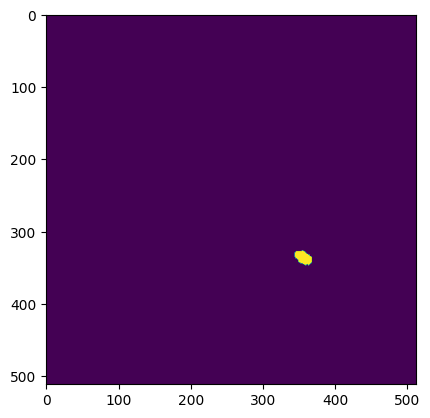

In [29]:
plt.imshow(burned_tiles_masks[1])

In [33]:
burned_tiles_masks[1].shape

(512, 512, 1)

In [62]:
burned_tiles_masks = [arr * 255 for arr in burned_tiles_masks]

In [35]:
test_123456 = np.moveaxis(burned_tiles_imgs[1], 0, -1)

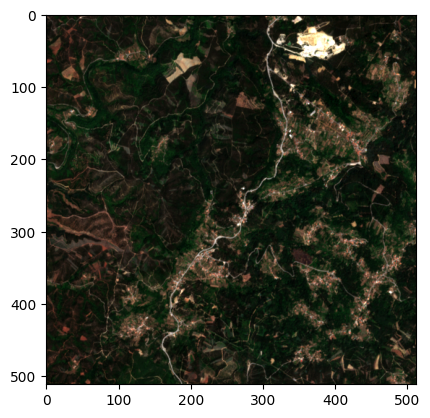

In [47]:
plt.imshow(test_123456.astype(int))

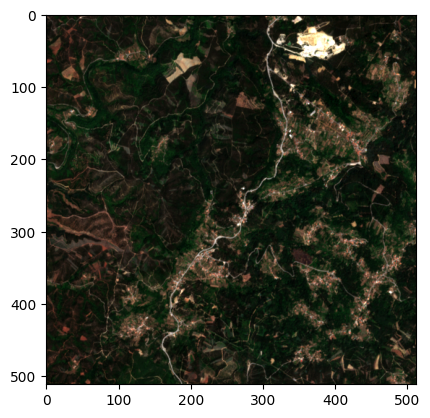

In [58]:
image_path = 'post_burned_tiles_dataset/imgs/img_2.png'  # Replace with your image mask file path
image_mask = cv2.imread(image_path)
plt.imshow(image_mask)

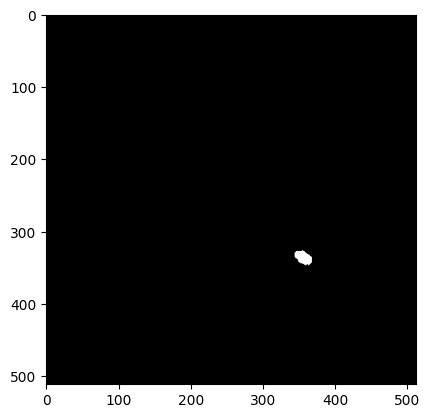

In [60]:
image_path = 'post_burned_tiles_dataset/masks/mask_2.png'  # Replace with your image mask file path
image_mask = cv2.imread(image_path)
plt.imshow(image_mask*255)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
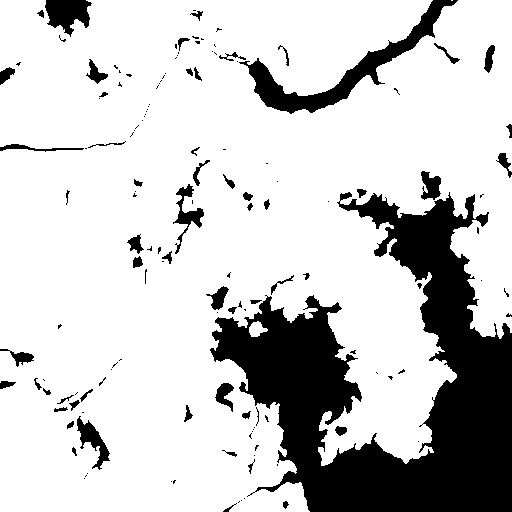

In [ ]:
burned_tiles_masks[100]*255

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
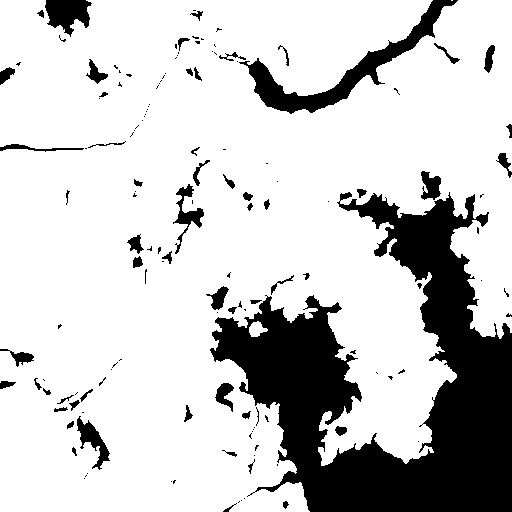

In [ ]:
burned_tiles_masks[100]

In [12]:
output_dir = 'post_burned_tiles_dataset/imgs'
os.makedirs(output_dir, exist_ok=True)

# Loop through the list and save each image as a .png file
for idx, img in enumerate(burned_tiles_imgs):
    # Construct the filename
    filename = os.path.join(output_dir, f'img_{idx + 1}.png')
    # Save the image
    cv2.imwrite(filename, img)

NameError: name 'burned_tiles_imgs' is not defined

In [68]:
!ls ./post_burned_tiles_dataset

imgs  masks


In [ ]:
output_dir = 'post_burned_tiles_dataset/masks'
os.makedirs(output_dir, exist_ok=True)

# Loop through the list and save each image as a .png file
for idx, img in enumerate(burned_tiles_masks):
    # Construct the filename
    filename = os.path.join(output_dir, f'mask_{idx + 1}.png')
    # Save the image
    cv2.imwrite(filename, img)

In [24]:
output_dir = 'post_burned_tiles_dataset/masks'
masks_file_names = []

# Loop through the list and save each image as a .png file
for idx, img in enumerate(burned_tiles_masks):
    # Construct the filename
    filename = os.path.join(output_dir, f'mask_{idx + 1}.png')
    # Save the image
    masks_file_names.append(filename)

NameError: name 'burned_tiles_masks' is not defined

In [ ]:
masks_file_names

In [53]:
from google.colab.patches import cv2_imshow

In [ ]:
!rm -r burned_tiles_dataset/masks

In [55]:
!du -sh post_burned_tiles_dataset/

183M	post_burned_tiles_dataset/


In [64]:
!mv post_burned_tiles_dataset/masks /content/drive/MyDrive/CS\ 269\ Final\ Project/post_burned_tiles_dataset/

mv: cannot stat 'post_burned_tiles_dataset/masks': No such file or directory


In [72]:
np.where(masked_tiles[1163] == 0)[0].size

NameError: name 'masked_tiles' is not defined

In [83]:
im = PILImage.create(f'post_burned_tiles_dataset/imgs/img_101.png')
msk = PILMask.create(f'post_burned_tiles_dataset/masks/mask_101.png')

In [84]:
np.unique(msk)

array([  0, 255], dtype=uint8)

In [7]:
def n_codes(fnames, is_partial=True):

  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [25]:
p2c = n_codes(masks_file_names)

{0: 0, 1: 255}


In [8]:
def get_msk(fn, p2c):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"

  # fn = p/fn
  a = fn.stem.split('_')[1]
  fn = Path(f'./post_burned_tiles_dataset/masks/mask_{a}.png')

  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

In [16]:
c = ["not_burned", "burned"]

In [17]:
get_y = lambda o: get_msk(o, p2c)

In [18]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(c)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(224),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [91]:
from pathlib import Path

In [20]:
p = Path('./')

In [26]:
dls = binary.dataloaders(p/'post_burned_tiles_dataset/imgs/', bs=8)

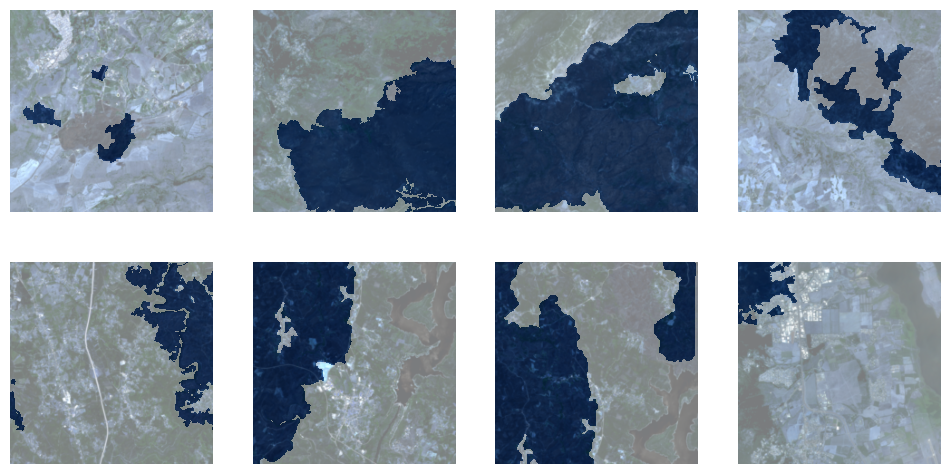

In [95]:
dls.show_batch(cmap='Blues', vmin=0, vmax=1)

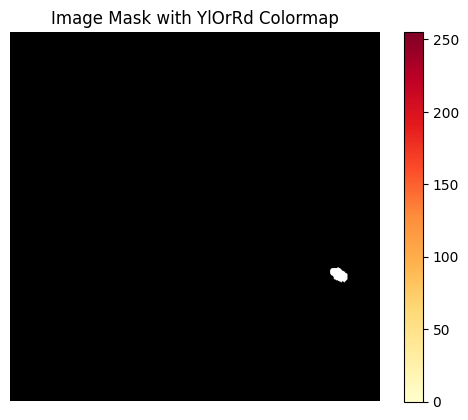

In [71]:
image_path = 'post_burned_tiles_dataset/masks/mask_1.png'  # Replace with your image mask file path
image_mask = cv2.imread(image_path)

# Check if the image mask was loaded successfully
if image_mask is None:
    print("Error: Could not load image mask.")
else:
    # Display the image mask with the specified colormap
    plt.imshow(image_mask, cmap='YlOrRd')
    plt.colorbar()  # Optional: to display a color bar
    plt.title('Image Mask with YlOrRd Colormap')
    plt.axis('off')  # Optional: to turn off the axis
    plt.show()

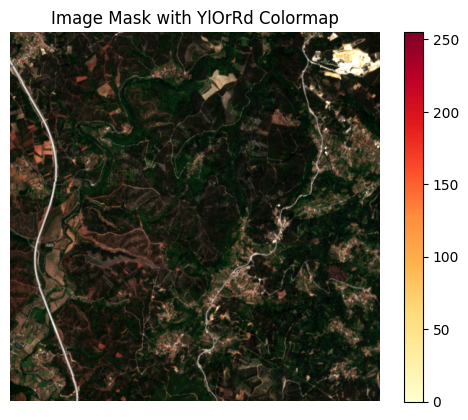

In [96]:
image_path = 'post_burned_tiles_dataset/imgs/img_1.png'  # Replace with your image mask file path
image_mask = cv2.imread(image_path)

# Check if the image mask was loaded successfully
if image_mask is None:
    print("Error: Could not load image mask.")
else:
    # Display the image mask with the specified colormap
    plt.imshow(image_mask, cmap='YlOrRd')
    plt.colorbar()  # Optional: to display a color bar
    plt.title('Image Mask with YlOrRd Colormap')
    plt.axis('off')  # Optional: to turn off the axis
    plt.show()

In [27]:
learn = unet_learner(dls, resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s]


In [28]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [98]:
learn.fit(30)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


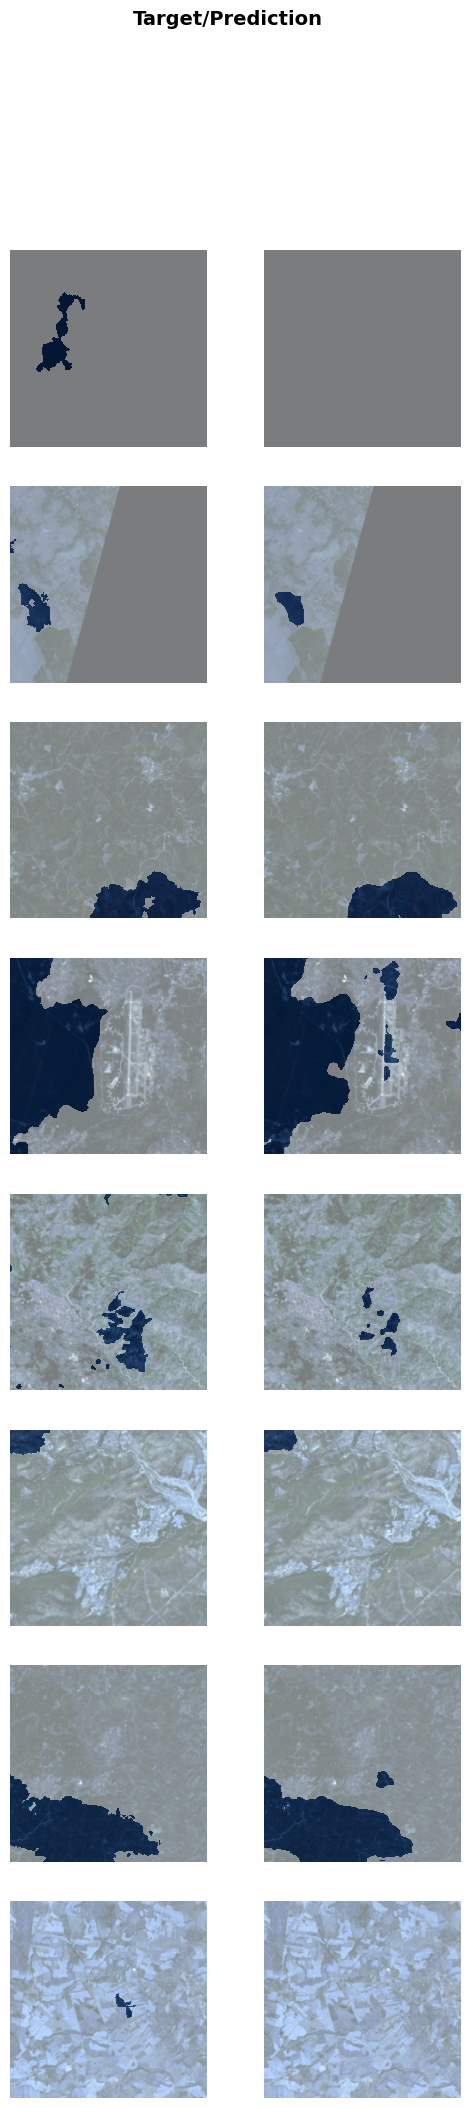

In [99]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

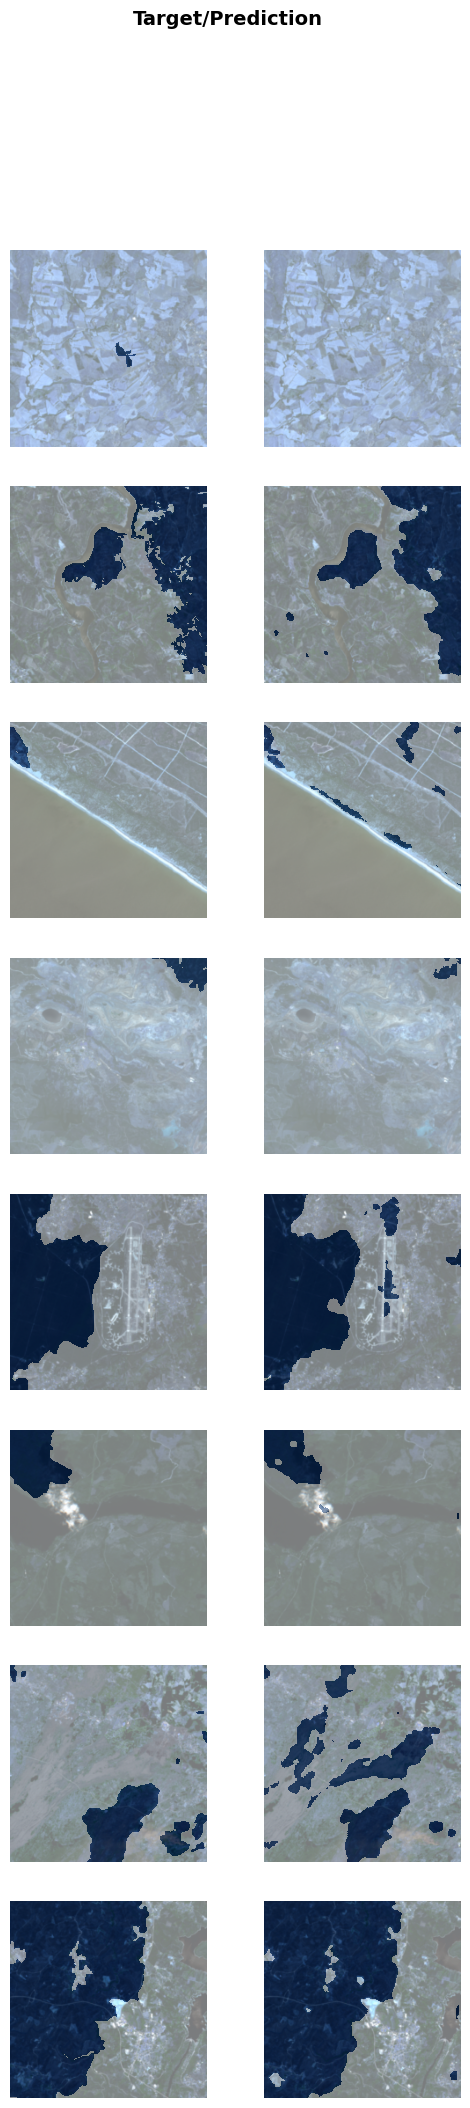

In [100]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

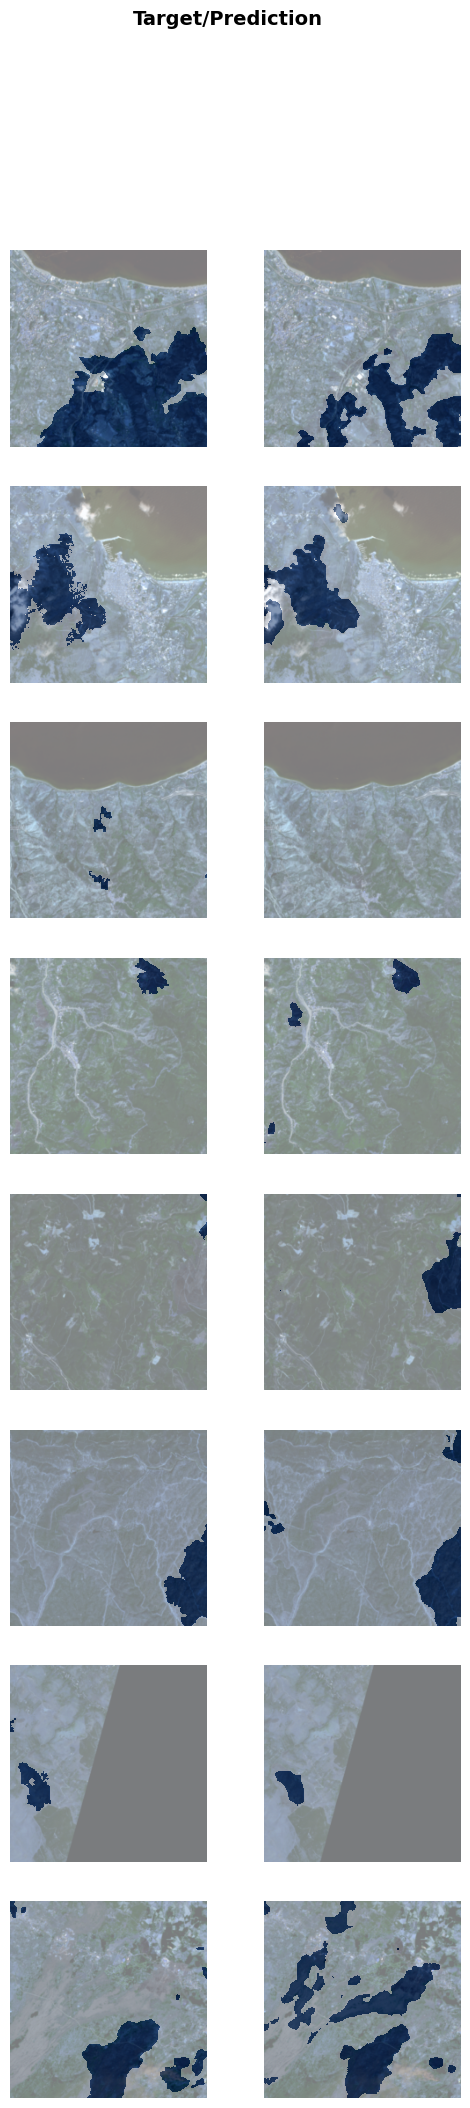

In [101]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

In [102]:
learn.save('fastai_resnet32_30epochs')

Path('models/fastai_resnet32_30epochs.pth')

In [103]:
learn = unet_learner(dls, resnet34)

In [104]:
learn.fit(50)

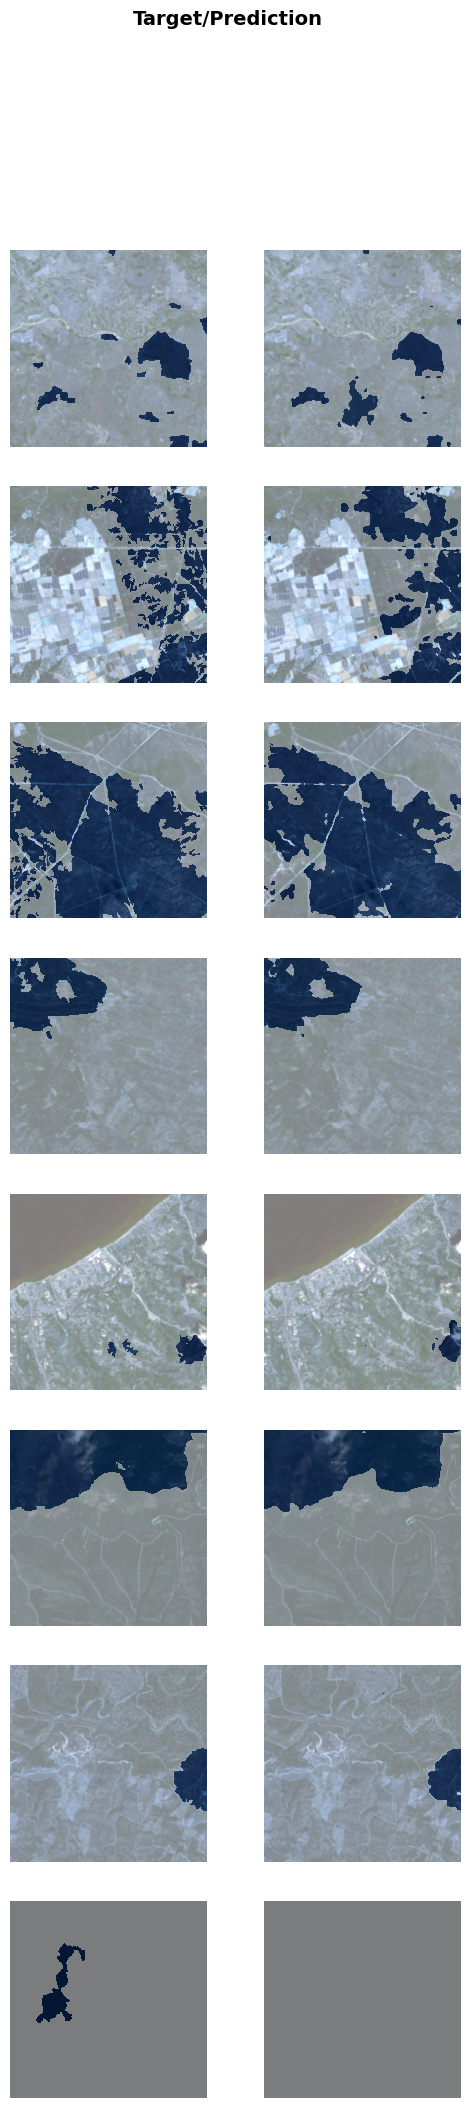

In [105]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

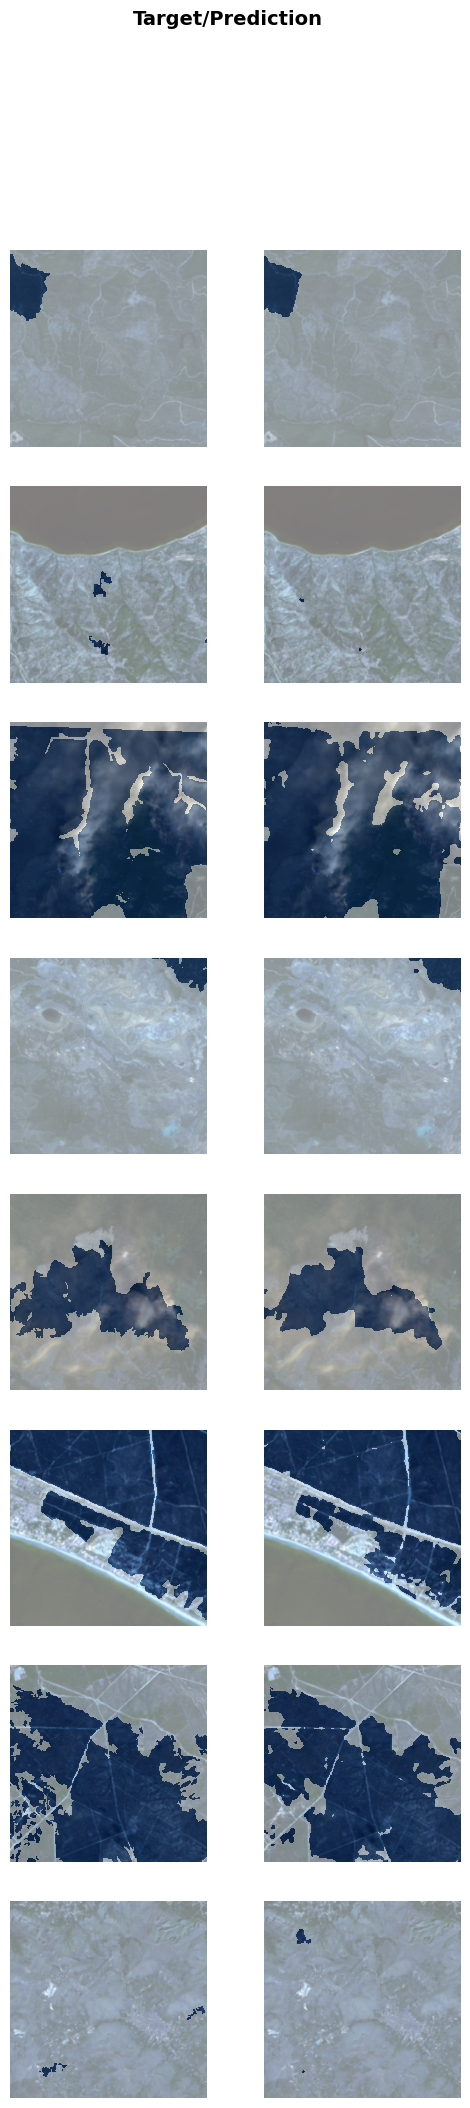

In [106]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

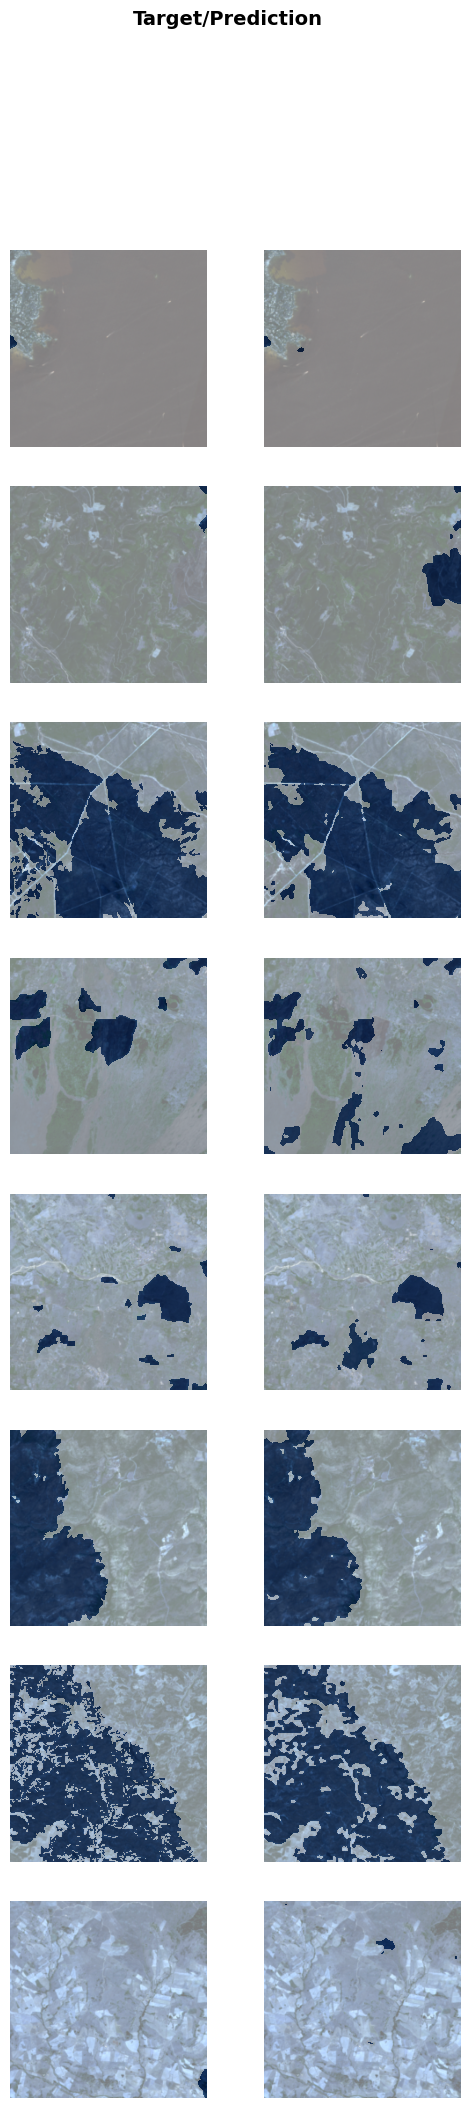

In [107]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

In [108]:
learn.save('fastai_resnet32_50epochs')

Path('models/fastai_resnet32_50epochs.pth')